In [1]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from PIL import Image

In [16]:
#: plotting functions
dashed_line = partial(plt.plot, color='black', linestyle='--', linewidth=3)
highlight_line = partial(plt.plot, color='black', linestyle='-', linewidth=9)
rect_plt = partial(plt.Rectangle, width=1, height=1, edgecolor='black', linewidth=3)
highlight_rect = partial(rect_plt, linewidth=9)
text_plt = partial(plt.text, fontweight=100, fontsize=30)
vert_text = partial(text_plt, rotation=90, horizontalalignment='right', verticalalignment='center')
horz_text = partial(text_plt, horizontalalignment='center', verticalalignment='bottom')
rect_text = partial(text_plt, horizontalalignment='center', verticalalignment='center')

In [14]:
def coo_plot(coo, darkcolor, lightcolor, fontsize=30, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    h, w = coo.shape
    
    def plot_static_img():
        plt.figure(figsize=figsize)

        #: dashed array grid
        for i in range(h + 1):
            dashed_line([0, w], [i, i])

        for j in range(w + 1):
            dashed_line([j, j], [0, h])

        #: fill data values in array format
        for x, y, val in zip(coo.col, coo.row, coo.data):
            x, y = xy = (x, h - y - 1)
            rect = rect_plt(xy, facecolor=lightcolor)
            plt.gca().add_patch(rect)
            rect_text(x + 0.5, y + 0.5, str(val))

        #: fill sparse format
        for i, (label, info) in enumerate(zip(['Row', 'Column', 'Data'], [coo.row, coo.col, coo.data])):
            text_plt((w + 1), (h - 0.75 - 2 * i), label)
            for j, val in enumerate(info):
                x, y = xy = ((w + j + 1), (h - 2 * (i + 1)))
                rect = rect_plt(xy, facecolor=lightcolor)
                plt.gca().add_patch(rect)
                rect_text(x + 0.5, y + 0.5, str(val))

        #: side labels
        vert_text(-1, (h / 2), 'Row')
        for i in reversed(range(h)):
            vert_text(0, (h - i - 0.5), str(i))

        horz_text((w / 2), (h + 1), 'Column')
        for i in range(w):
            horz_text(i + 0.5, h, str(i))
            
        #: format graph
        plt.text(0, -0.5, '© Matt Eding')
        plt.axis('equal')
        plt.axis('off')

    #: highlight relationships
    for i, (r, c) in enumerate(zip(row, col)):
        for a, alpha in enumerate(np.r_[0:1:10j, [1]*5, 1:0:10j]):
            plot_static_img()
            for j in range(3):
                xy = ((w + i + 1), (h - 2 * (j + 1)))
                rect = highlight_rect(xy, facecolor=darkcolor, alpha=alpha)  # sparse part
                plt.gca().add_patch(rect)

            xy = (c, (h - r - 1))
            rect = highlight_rect(xy, facecolor=darkcolor, alpha=alpha)  # array part
            plt.gca().add_patch(rect)

            highlight_line([0, c], [h - r - 0.5] * 2, alpha=alpha)  # horz line
            highlight_line([c + 0.5] * 2, [h - r, h], alpha=alpha)  # vert line
            plt.savefig(f'coo_{i:0>4}_{a:0>4}.png')
            plt.close()  # free memory
    
    #: make GIF and remove temp PNG's
    cwd = Path.cwd()
    paths = sorted(p for p in cwd.iterdir() if 'png' in p.suffix)

    imgs = [Image.open(p) for p in paths]
    for _ in range(10):
        imgs.insert(0, imgs[0])  # make start last longer
    imgs[0].save('coo.gif', save_all=True, append_images=imgs, duration=100, loop=0)
    
    for p in paths:
        p.unlink()

In [15]:
row = [1, 3, 0, 2, 4]
col = [1, 4, 2, 3, 3]
data = [2, 4, 9, 1, 4]
coo = sparse.coo_matrix((data, (row, col)), shape=(6, 7))
coo_plot(coo, darkcolor='orchid', lightcolor='plum')

<Figure size 1440x720 with 0 Axes>

In [444]:
def dia_plot(dia, darkcolor, lightcolor, fontsize=30, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    h, w = dia.shape
    
    def plot_static_img():
        plt.figure(figsize=figsize)
        
        #: dashed array grid
        for i in range(h + 1):
            dashed_line([0, w], [i, i])

        for j in range(w + 1):
            dashed_line([j, j], [0, h])

        #: fill data values in array format
        coo = dia.tocoo()
        for x, y, val in zip(coo.col, coo.row, coo.data):
            x, y = xy = (x, h - y - 1)
            rect = rect_plt(xy, facecolor=lightcolor)
            plt.gca().add_patch(rect)
            rect_text(x + 0.5, y + 0.5, str(val))

        #: fill sparse format
        text_plt((w + 1), (h - 0.75), 'Offset')
        for i, (val) in enumerate(dia.offsets):
            x, y = xy = ((w + i + 1), (h - 2))
            rect = rect_plt(xy, facecolor=lightcolor)
            plt.gca().add_patch(rect)
            rect_text(x + 0.5, y + 0.5, str(val))
        
        text_plt((w + 1), (h - 2.75), 'Data')
        for i, row in enumerate(dia.data):
            for j, val in enumerate(row):
                x, y = xy = ((w + j + 1), (h - i - 4))
                rect = rect_plt(xy, facecolor=lightcolor)
                plt.gca().add_patch(rect)
                rect_text(x + 0.5, y + 0.5, str(val))
        
        #: format graph
        plt.text(0, -0.5, '© Matt Eding')
        plt.axis('equal')
        plt.axis('off')
        
    plot_static_img() ### normally during highlight steps

    #: highlight relationships
    data = dia.tocoo().todia().data  # reformat dia.data to have falsy values where excess data
    lex = np.lexsort(dia.offsets[np.newaxis])  # new data did not preserve order
    for i, (offset, d_row) in enumerate(zip(dia.offsets, data[lex])):

#         if i != 2:  ######
#             continue  ####
            
        #: highlight offset
        xy = ((w + i + 1), h - 2)
        rect = highlight_rect(xy, facecolor=darkcolor)
        plt.gca().add_patch(rect)
        
        #: highlight data
        for j, val in enumerate(d_row):
            xy = ((w + j + 1), (h - i - 4))
            color = darkcolor if val else 'none'
            rect = highlight_rect(xy, facecolor=color)
            plt.gca().add_patch(rect)

        #: highlight diagonal
        eye = np.eye(*dia.shape, k=offset, dtype=dia.dtype)
        coo = sparse.coo_matrix(eye)
        for x, y, val in zip(coo.col, coo.row, coo.data):
            x, y = xy = (x, h - y - 1)
            rect = highlight_rect(xy, facecolor=darkcolor)
            plt.gca().add_patch(rect)
            
        for k in np.r_[(0.0 * np.sign(offset)):offset:complex(abs(offset) + 1)]:
            eye = np.eye(*dia.shape, k=int(k), dtype=dia.dtype)
            coo = sparse.coo_matrix(eye)
            for x, y, val in zip(coo.col, coo.row, coo.data):
                xy = (x, (h - y - 1))
                rect = highlight_rect(xy, facecolor='none', alpha=1)
                plt.gca().add_patch(rect)
                
            if offset <= 0:
                x, y = -0.1, (h + k + 0.5)
            else:
                x, y = (k - 0.1), (h + 0.5)
            s = f'{k:+.0f}'
            rect_text(x, y, s, fontweight=1000, ha='right', va='top')
        
#         plt.savefig(f'coo_{i:0>4}_{a:0>4}.png')
#         plt.close()  # free memory
    
    #: make GIF and remove temp PNG's
#     cwd = Path.cwd()
#     paths = sorted(p for p in cwd.iterdir() if 'png' in p.suffix)

#     imgs = [Image.open(p) for p in paths]
#     for _ in range(10):
#         imgs.insert(0, imgs[0])  # make start last longer
#     imgs[0].save('dia.gif', save_all=True, append_images=imgs, duration=100, loop=0)
    
#     for p in paths:
#         p.unlink()

array([ 0, -3,  2], dtype=int32)

<Figure size 1440x720 with 0 Axes>

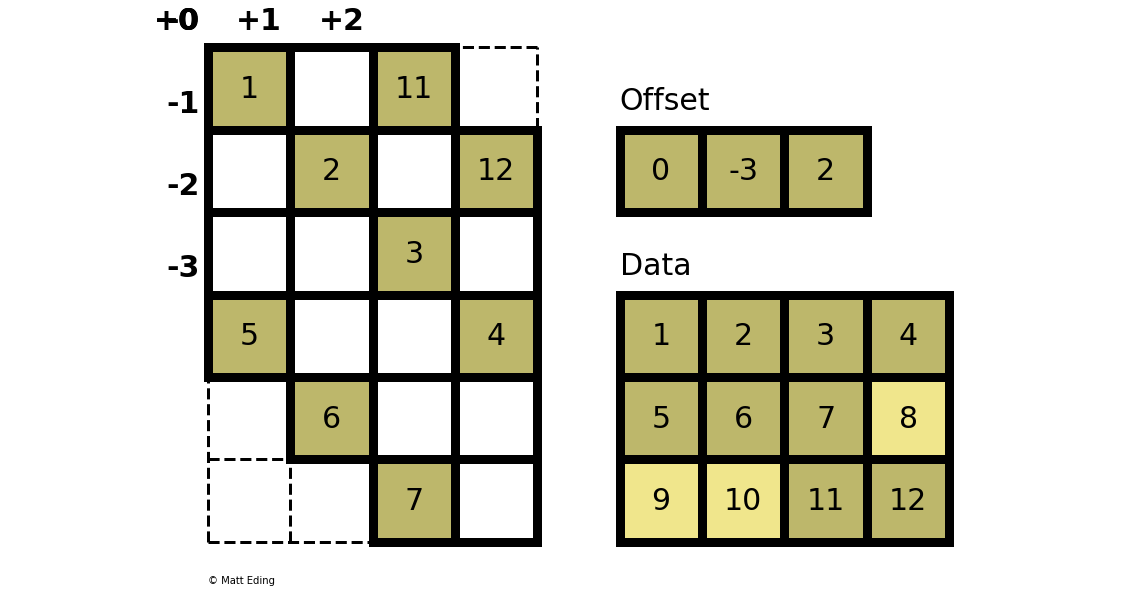

In [445]:
data = np.arange(12).reshape(3, 4) + 1
offsets = np.array([0, -3, 2])
dia = sparse.dia_matrix((data, offsets), shape=(6, 4))
dia.toarray()
dia_plot(dia, 'darkkhaki', 'khaki')
dia.data
dia.offsets

In [314]:
dia

<6x4 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements (3 diagonals) in DIAgonal format>

In [377]:
dia.data.size, dia.nnz

(12, 9)

In [189]:
data = np.arange(12).reshape(3, 4) + 1
offsets = np.array([0, -3, 2])
sparse.dia_matrix((data, offsets), shape=(6, 4)).toarray()

array([[ 1,  0, 11,  0],
       [ 0,  2,  0, 12],
       [ 0,  0,  3,  0],
       [ 5,  0,  0,  4],
       [ 0,  6,  0,  0],
       [ 0,  0,  7,  0]])

In [216]:
eye = np.eye(*dia.shape, k=dia.offsets[0], dtype=dia.dtype)
sparse.coo_matrix(eye)

<6x4 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in COOrdinate format>

In [405]:
arr = dia.tocoo().todia().data
lex = np.lexsort(dia.offsets[np.newaxis])
arr[lex]

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  0],
       [ 0,  0, 11, 12]])

In [399]:
offsets[np.newaxis]

array([[ 0, -3,  2]])

In [391]:
dia.toarray()

array([[ 1,  0, 11,  0],
       [ 0,  2,  0, 12],
       [ 0,  0,  3,  0],
       [ 5,  0,  0,  4],
       [ 0,  6,  0,  0],
       [ 0,  0,  7,  0]])